In [ ]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4' 

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator


E0000 00:00:1743918132.054112 1002654 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743918132.068467 1002654 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743918132.161042 1002654 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743918132.161065 1002654 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743918132.161068 1002654 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743918132.161071 1002654 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# GLOBAL VARIABLES
dataset = "animals"
base_dir = os.path.join("datasets", dataset)
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
augmented_dir = os.path.join(base_dir, "aug")
os.makedirs(augmented_dir, exist_ok=True)

models_dir = os.path.join("models", dataset)
os.makedirs(models_dir, exist_ok=True)

metadata_file = os.path.join(models_dir, "metadata.csv")
metrics_file = os.path.join(models_dir, "metrics.csv")

# HYPERPARAMETERS
HYPERPARAMETERS = {
    "model_version": 8,
    # Image processing
    "img_width": 64,
    "img_height": 64,
    "rescale": 1.0 / 255,
    "rotation_range": 10,
    "width_shift_range": 0.2,
    "zoom_range": 0.3,
    "horizontal_flip": True,
    # Training
    "batch_size": 64,
    # Model
    "num_classes": 135,
    "learning_rate": 0.00001,
    # "conv_layers": 10,
    # "conv_shape": (3, 3), 
    # "pool_shape": (2, 2),
    # "internal_neurons": 256
}

epochs = 10

In [4]:
import hashlib

# USING THE HYPERPARAMETERS GENERATE A KEY (HASH)
def generate_hash():
    hash_input = ""
    for key, value in HYPERPARAMETERS.items():
        if isinstance(value, list):
            value = str(value)
        hash_input += f"{key}:{value};"
    # Generate a hash
    return hashlib.md5(hash_input.encode()).hexdigest()

In [5]:
hash_key = generate_hash()

if not os.path.exists(metadata_file):
    cols = ["hash_key"]
    cols.extend(HYPERPARAMETERS.keys())
    metadata = pd.DataFrame(columns=cols)
    metadata.to_csv(metadata_file, index=False)
    
metadata = pd.read_csv(metadata_file)
if hash_key not in metadata["hash_key"].values:
    metadata = pd.read_csv(metadata_file)
    new_row = {**HYPERPARAMETERS, "hash_key": hash_key}
    metadata = pd.concat([metadata, pd.DataFrame([new_row])], ignore_index=True)
    metadata.to_csv(metadata_file, index=False)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=HYPERPARAMETERS["horizontal_flip"],
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"]),
    batch_size=HYPERPARAMETERS["batch_size"],
    class_mode="binary",
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    class_mode="binary",
    target_size=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"]),
    batch_size=20,
)

Found 26120 images belonging to 135 classes.


In [7]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(
    layers.Input(
        shape=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"], 3),
    )
)

model.add(
    layers.Conv2D(64, kernel_size=3, activation="relu", padding="same", strides=2)
)
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, kernel_size=3, activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))


model.add(layers.Conv2D(256, kernel_size=3, activation="relu", padding="same"))
model.add(layers.Conv2D(256, kernel_size=3, activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))


model.add(layers.Conv2D(512, kernel_size=3, activation="relu", padding="same"))
model.add(layers.Conv2D(512, kernel_size=3, activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))


model.add(layers.Conv2D(512, kernel_size=3, activation="relu", padding="same"))
model.add(layers.Conv2D(512, kernel_size=3, activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))


model.add(layers.Flatten())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(HYPERPARAMETERS["num_classes"], activation="softmax"))

model.summary()

I0000 00:00:1743918135.422287 1002654 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4084 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 12,512,519 (47.73 MB)

 Trainable params: 12,509,575 (47.72 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(models_dir, hash_key, "{epoch:02d}", "model-{val_loss:.4f}.keras"),
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,
        min_lr=0.000001,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
    ),
]

In [8]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=HYPERPARAMETERS["learning_rate"]),
    metrics=["acc"],
)

In [12]:
histories = []

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=test_generator,
)

histories.append(history)

Training 1...
Epoch 1/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 75s 182ms/step - acc: 0.0540 - loss: 4.4726 - val_acc: 0.0347 - val_loss: 4.7739
Epoch 2/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 72s 175ms/step - acc: 0.0581 - loss: 4.4472 - val_acc: 0.0398 - val_loss: 4.7566
Epoch 3/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 75s 184ms/step - acc: 0.0583 - loss: 4.4319 - val_acc: 0.0370 - val_loss: 4.7427
Epoch 4/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 74s 182ms/step - acc: 0.0586 - loss: 4.4206 - val_acc: 0.0389 - val_loss: 4.7466
Epoch 5/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 74s 182ms/step - acc: 0.0598 - loss: 4.4215 - val_acc: 0.0389 - val_loss: 4.7199
Epoch 6/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 76s 186ms/step - acc: 0.0605 - loss: 4.4039 - val_acc: 0.0373 - val_loss: 4.7551
Epoch 7/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 75s 183ms/step - acc: 0.0609 - loss: 4.3851 - val_acc: 0.0408 - val_loss: 4.7385
Epoch 8/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 77s 187ms/step - acc: 0.0632 - loss: 4.3836 - val_acc: 0.0389 - val_loss: 4.7276
Epoch 9/10
409/409

Training 2...
Epoch 1/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 76s 186ms/step - acc: 0.0702 - loss: 4.3379 - val_acc: 0.0443 - val_loss: 4.6851
Epoch 2/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 75s 183ms/step - acc: 0.0669 - loss: 4.3415 - val_acc: 0.0443 - val_loss: 4.6929
Epoch 3/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 75s 184ms/step - acc: 0.0727 - loss: 4.3278 - val_acc: 0.0421 - val_loss: 4.7158
Epoch 4/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 74s 181ms/step - acc: 0.0708 - loss: 4.3098 - val_acc: 0.0402 - val_loss: 4.7193
Epoch 5/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 72s 177ms/step - acc: 0.0707 - loss: 4.2984 - val_acc: 0.0443 - val_loss: 4.6761
Epoch 6/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 72s 177ms/step - acc: 0.0711 - loss: 4.2911 - val_acc: 0.0465 - val_loss: 4.6575
Epoch 7/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 72s 177ms/step - acc: 0.0758 - loss: 4.2793 - val_acc: 0.0437 - val_loss: 4.6876
Epoch 8/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 78s 190ms/step - acc: 0.0769 - loss: 4.2773 - val_acc: 0.0462 - val_loss: 4.6534
Epoch 9/10
409/409

Training 3...
Epoch 1/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 75s 182ms/step - acc: 0.0803 - loss: 4.2501 - val_acc: 0.0437 - val_loss: 4.6710
Epoch 2/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 73s 178ms/step - acc: 0.0780 - loss: 4.2485 - val_acc: 0.0510 - val_loss: 4.6170
Epoch 3/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 74s 181ms/step - acc: 0.0826 - loss: 4.2160 - val_acc: 0.0488 - val_loss: 4.6311
Epoch 4/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 73s 179ms/step - acc: 0.0830 - loss: 4.2114 - val_acc: 0.0484 - val_loss: 4.6401
Epoch 5/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 74s 182ms/step - acc: 0.0843 - loss: 4.2013 - val_acc: 0.0535 - val_loss: 4.5888
Epoch 6/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 74s 182ms/step - acc: 0.0814 - loss: 4.2012 - val_acc: 0.0491 - val_loss: 4.6453
Epoch 7/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 75s 182ms/step - acc: 0.0815 - loss: 4.1909 - val_acc: 0.0529 - val_loss: 4.5945
Epoch 8/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 76s 185ms/step - acc: 0.0888 - loss: 4.1683 - val_acc: 0.0516 - val_loss: 4.5987
Epoch 9/10
409/409

Training 4...
Epoch 1/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 75s 182ms/step - acc: 0.0910 - loss: 4.1438 - val_acc: 0.0516 - val_loss: 4.5846
Epoch 2/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 74s 180ms/step - acc: 0.0902 - loss: 4.1516 - val_acc: 0.0590 - val_loss: 4.5914
Epoch 3/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 76s 187ms/step - acc: 0.0945 - loss: 4.1190 - val_acc: 0.0567 - val_loss: 4.6089
Epoch 4/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 77s 189ms/step - acc: 0.0929 - loss: 4.1104 - val_acc: 0.0532 - val_loss: 4.5937
Epoch 5/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 72s 176ms/step - acc: 0.0935 - loss: 4.1111 - val_acc: 0.0628 - val_loss: 4.5252
Epoch 6/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 75s 184ms/step - acc: 0.0981 - loss: 4.1005 - val_acc: 0.0551 - val_loss: 4.6082
Epoch 7/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 76s 186ms/step - acc: 0.1024 - loss: 4.0943 - val_acc: 0.0577 - val_loss: 4.5674
Epoch 8/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 74s 180ms/step - acc: 0.0991 - loss: 4.0898 - val_acc: 0.0586 - val_loss: 4.5604
Epoch 9/10
409/409

Training 5...
Epoch 1/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 75s 184ms/step - acc: 0.0987 - loss: 4.0635 - val_acc: 0.0656 - val_loss: 4.5006
Epoch 2/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 76s 185ms/step - acc: 0.1045 - loss: 4.0447 - val_acc: 0.0580 - val_loss: 4.5240
Epoch 3/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 77s 187ms/step - acc: 0.1077 - loss: 4.0236 - val_acc: 0.0631 - val_loss: 4.5087
Epoch 4/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 77s 188ms/step - acc: 0.1091 - loss: 4.0237 - val_acc: 0.0723 - val_loss: 4.4609
Epoch 5/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 72s 177ms/step - acc: 0.1089 - loss: 4.0125 - val_acc: 0.0618 - val_loss: 4.5425
Epoch 6/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 77s 187ms/step - acc: 0.1104 - loss: 4.0061 - val_acc: 0.0679 - val_loss: 4.4844
Epoch 7/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 73s 178ms/step - acc: 0.1148 - loss: 3.9729 - val_acc: 0.0682 - val_loss: 4.4860
Epoch 8/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 81s 198ms/step - acc: 0.1121 - loss: 3.9785 - val_acc: 0.0637 - val_loss: 4.4978
Epoch 9/10
409/409

Training 6...
Epoch 1/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 74s 180ms/step - acc: 0.1159 - loss: 3.9628 - val_acc: 0.0698 - val_loss: 4.4870
Epoch 2/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 76s 186ms/step - acc: 0.1189 - loss: 3.9483 - val_acc: 0.0755 - val_loss: 4.4604
Epoch 3/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 73s 179ms/step - acc: 0.1232 - loss: 3.9246 - val_acc: 0.0727 - val_loss: 4.5056
Epoch 4/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 76s 186ms/step - acc: 0.1224 - loss: 3.9201 - val_acc: 0.0755 - val_loss: 4.4606
Epoch 5/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 73s 178ms/step - acc: 0.1222 - loss: 3.9131 - val_acc: 0.0711 - val_loss: 4.4746
Epoch 6/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 73s 178ms/step - acc: 0.1211 - loss: 3.9226 - val_acc: 0.0679 - val_loss: 4.4982
Epoch 7/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 76s 187ms/step - acc: 0.1254 - loss: 3.8783 - val_acc: 0.0704 - val_loss: 4.4728
Epoch 8/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 74s 182ms/step - acc: 0.1317 - loss: 3.8692 - val_acc: 0.0717 - val_loss: 4.4821
Epoch 9/10
409/409

Training 7...
Epoch 1/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 76s 185ms/step - acc: 0.1264 - loss: 3.8630 - val_acc: 0.0755 - val_loss: 4.4592
Epoch 2/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 76s 186ms/step - acc: 0.1335 - loss: 3.8396 - val_acc: 0.0739 - val_loss: 4.4757
Epoch 3/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 73s 179ms/step - acc: 0.1338 - loss: 3.8426 - val_acc: 0.0762 - val_loss: 4.4408
Epoch 4/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 76s 186ms/step - acc: 0.1327 - loss: 3.8203 - val_acc: 0.0774 - val_loss: 4.4241
Epoch 5/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 75s 183ms/step - acc: 0.1307 - loss: 3.8201 - val_acc: 0.0787 - val_loss: 4.4601
Epoch 6/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 75s 183ms/step - acc: 0.1374 - loss: 3.8117 - val_acc: 0.0746 - val_loss: 4.4673
Epoch 7/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 75s 183ms/step - acc: 0.1355 - loss: 3.8092 - val_acc: 0.0800 - val_loss: 4.4877
Epoch 8/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 76s 186ms/step - acc: 0.1384 - loss: 3.7935 - val_acc: 0.0822 - val_loss: 4.4673
Epoch 9/10
409/409

Training 8...
Epoch 1/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 76s 187ms/step - acc: 0.1418 - loss: 3.7828 - val_acc: 0.0800 - val_loss: 4.4572
Epoch 2/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 76s 187ms/step - acc: 0.1475 - loss: 3.7631 - val_acc: 0.0848 - val_loss: 4.4208
Epoch 3/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 74s 181ms/step - acc: 0.1414 - loss: 3.7640 - val_acc: 0.0854 - val_loss: 4.4234
Epoch 4/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 74s 181ms/step - acc: 0.1473 - loss: 3.7363 - val_acc: 0.0844 - val_loss: 4.4278
Epoch 5/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 76s 185ms/step - acc: 0.1501 - loss: 3.7366 - val_acc: 0.0848 - val_loss: 4.4398
Epoch 6/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 73s 179ms/step - acc: 0.1527 - loss: 3.7147 - val_acc: 0.0921 - val_loss: 4.3842
Epoch 7/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 74s 181ms/step - acc: 0.1513 - loss: 3.7253 - val_acc: 0.0880 - val_loss: 4.4281
Epoch 8/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 74s 182ms/step - acc: 0.1560 - loss: 3.6904 - val_acc: 0.0883 - val_loss: 4.4154
Epoch 9/10
409/409

Training 9...
Epoch 1/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 77s 189ms/step - acc: 0.1550 - loss: 3.6742 - val_acc: 0.0883 - val_loss: 4.3895
Epoch 2/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 79s 192ms/step - acc: 0.1609 - loss: 3.6607 - val_acc: 0.0918 - val_loss: 4.4007
Epoch 3/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 81s 197ms/step - acc: 0.1611 - loss: 3.6456 - val_acc: 0.0889 - val_loss: 4.4400
Epoch 4/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 75s 183ms/step - acc: 0.1626 - loss: 3.6432 - val_acc: 0.0918 - val_loss: 4.4014
Epoch 5/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 72s 177ms/step - acc: 0.1690 - loss: 3.6214 - val_acc: 0.0921 - val_loss: 4.4347
Epoch 6/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 78s 190ms/step - acc: 0.1643 - loss: 3.6285 - val_acc: 0.0956 - val_loss: 4.3974
Epoch 7/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 83s 202ms/step - acc: 0.1683 - loss: 3.6278 - val_acc: 0.0940 - val_loss: 4.4739
Epoch 8/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 82s 201ms/step - acc: 0.1708 - loss: 3.6022 - val_acc: 0.0883 - val_loss: 4.4282
Epoch 9/10
409/409

Training 10...
Epoch 1/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 79s 192ms/step - acc: 0.1728 - loss: 3.5883 - val_acc: 0.0966 - val_loss: 4.4181
Epoch 2/10
360/409 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - acc: 0.1732 - loss: 3.5828

KeyboardInterrupt: 

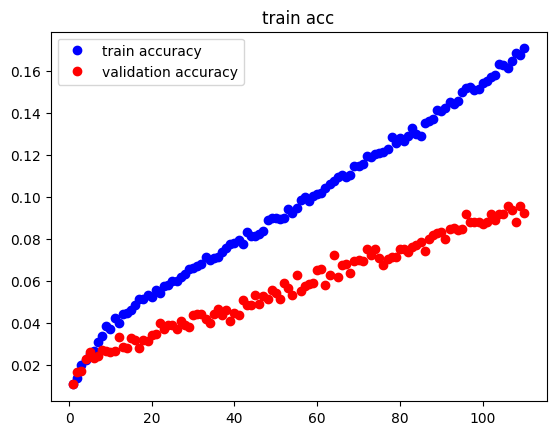

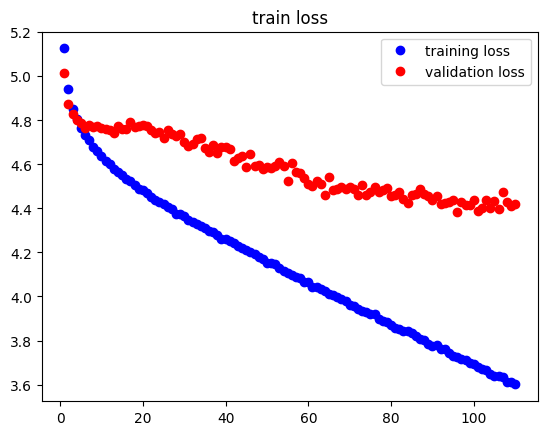

In [19]:
acc = histories[0].history['acc']
for i in range(1, len(histories)):
    acc = np.concatenate((acc, histories[i].history['acc']))

val_acc = histories[0].history['val_acc']
for i in range(1, len(histories)):
    val_acc = np.concatenate((val_acc, histories[i].history['val_acc']))

loss = histories[0].history['loss']
for i in range(1, len(histories)):
    loss = np.concatenate((loss, histories[i].history['loss']))

val_loss = histories[0].history['val_loss']
for i in range(1, len(histories)):
    val_loss = np.concatenate((val_loss, histories[i].history['val_loss']))

epochs_range = range(1, len(acc) + 1)

plt.plot(epochs_range, acc, "bo", label="train accuracy")
plt.plot(epochs_range, val_acc, "ro", label="validation accuracy")
plt.title("train acc")
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, "bo", label="training loss")
plt.plot(epochs_range, val_loss, "ro", label="validation loss")
plt.title("train loss")
plt.legend()

plt.show()

In [ ]:
test_generator.reset()
test_loss, test_acc = model.evaluate(test_generator)
print("\ntest acc :\n", test_acc)